# Image Captioning Multiple Training and Analysis

## Data Preparation

### Importing Dataset

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')
# awsaf49_coco_2017_dataset_path = kagglehub.dataset_download('awsaf49/coco-2017-dataset')

print('Data source import complete.')


100%|██████████| 1.04G/1.04G [00:12<00:00, 87.2MB/s]

Extracting files...


Data source import complete.


### Importing Libraries

In [ ]:
import os
import shutil
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from sklearn.model_selection import train_test_split

# from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, InceptionV3
# from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.models import Model


### Setting path to Relevent data

In [ ]:
image_dir = os.path.join(flickr8k_path,'Images')
caption_path = os.path.join(flickr8k_path,'captions.txt')

### Loading Data

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "<start> "+data['caption']+" <end>"
    return data

In [ ]:
# Captions
df = pd.read_csv(caption_path)
df = df.iloc[:-5]
df_preprocessed = text_preprocessing(df)
captions_list = df['caption'].tolist()

print(f"Total Image Count: {len(captions_list)}")

Total Image Count: 40450


In [ ]:
# Images
# img_path_list = [os.path.join(image_dir,img) for img in df['image'].tolist()]
imagename_list =  df['image'].tolist()
img_path_set = set(imagename_list)
print(f"Total Image Count: {len(imagename_list)}", f"\nUnique Image Count: {len(img_path_set)}")

Total Image Count: 40450 
Unique Image Count: 8090


In [ ]:
for i, j in zip(imagename_list[:10], captions_list[:10]):
    print(i, " | ", j)

1000268201_693b08cb0e.jpg  |  <start> child in pink dress is climbing up set of stairs in an entry way <end>
1000268201_693b08cb0e.jpg  |  <start> girl going into wooden building <end>
1000268201_693b08cb0e.jpg  |  <start> little girl climbing into wooden playhouse <end>
1000268201_693b08cb0e.jpg  |  <start> little girl climbing the stairs to her playhouse <end>
1000268201_693b08cb0e.jpg  |  <start> little girl in pink dress going into wooden cabin <end>
1001773457_577c3a7d70.jpg  |  <start> black dog and spotted dog are fighting <end>
1001773457_577c3a7d70.jpg  |  <start> black dog and tri-colored dog playing with each other on the road <end>
1001773457_577c3a7d70.jpg  |  <start> black dog and white dog with brown spots are staring at each other in the street <end>
1001773457_577c3a7d70.jpg  |  <start> two dogs of different breeds looking at each other on the road <end>
1001773457_577c3a7d70.jpg  |  <start> two dogs on pavement moving toward each other <end>


### Tokenization

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(captions_list)
vocab_size = len(tokenizer.word_index) + 1
caption_lengths = [len(caption.split()) for caption in captions_list]
max_length = max(caption_lengths)

print(f"Vocabulary Size: {vocab_size}", f"\nMax Length: {max_length}")
print(f"Document Count: {tokenizer.document_count}", f"\nFilters: {tokenizer.filters}")

Vocabulary Size: 8483 
Max Length: 34
Document Count: 40450 
Filters: !"#$%&()*+,-./:;<=>?@[\]^_`{|}~	



### Spliting Dataset into train test and val

In [ ]:
train_img, val_img, train_cap, val_cap = train_test_split(imagename_list, captions_list, train_size=0.80, shuffle=False)
val_img, test_img, val_cap, test_cap = train_test_split(val_img, val_cap, train_size=0.75, shuffle=False)

print(f"Train Image Count: {len(train_img)}", f"\nVal Image Count: {len(val_img)}", f"\nTest Image Count: {len(test_img)}")
print(f"Train Caption Count: {len(train_cap)}", f"\nVal Caption Count: {len(val_cap)}", f"\nTest Caption Count: {len(test_cap)}")

Train Image Count: 32360 
Val Image Count: 6067 
Test Image Count: 2023
Train Caption Count: 32360 
Val Caption Count: 6067 
Test Caption Count: 2023


## Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, imagename_list, encoder, captions_list, tokenizer, max_length, batch_size):
        self.batch_size = batch_size

        self.encoder = encoder
        self.imagename_list = imagename_list
        self.image_feature_paths = []
        self.image_model_name = encoder.image_model_name

        self.captions_list = captions_list
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = (len(self.tokenizer.word_index) + 1)
        self.image_features = {}

    def run_img_feature_extractor(self, img_feature_dir, name):
        imagename_set = set(self.imagename_list)
        for imgname in imagename_set:
            image = self._load_image(os.path.join(image_dir, imgname))

            feature = self.encoder(image[np.newaxis, ...])
            self.image_features[imgname] = feature

            # img_feature_path = os.path.join(img_feature_dir, (imgname+'.npy'))
            # self.image_feature_paths.append(img_feature_path)
            # np.save(img_feature_path, feature)

        # self.image_feature_paths = [os.path.join(img_feature_dir, (imgname+'.npy')) for imgname in self.imagename_list]
        with open(os.path.join(img_feature_dir,(name+'_image_features.pkl')), 'wb') as f:
            pickle.dump(self.image_features, f)

        # return self.image_features

    def __len__(self):
        """Return the total number of batches."""
        return int(np.ceil(len(self.imagename_list) / self.batch_size))

    def _load_image(self, img_path):
        #Load and preprocess the image.
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(self.encoder.image_size, self.encoder.image_size))
        image = tf.keras.preprocessing.image.img_to_array(image)

        if self.encoder.image_model_name.lower() == 'densenet':
            image = tf.keras.applications.densenet.preprocess_input(image)
        elif self.encoder.image_model_name.lower() == 'vgg16':
            image = tf.keras.applications.vgg16.preprocess_input(image)
        elif self.encoder.image_model_name.lower() == 'resnet':
            image = tf.keras.applications.resnet.preprocess_input(image)
        elif self.encoder.image_model_name.lower() == 'inceptionv3':
            image = tf.keras.applications.inception_v3.preprocess_input(image)
        else:
            raise ValueError("Unsupported model name")
        return image

    def _load_image_features(self, feature_file_path):
        """Load image features from pickle file."""
        if not os.path.exists(feature_file_path):
            raise FileNotFoundError(f"Feature file not found: {feature_file_path}")

        with open(feature_file_path, 'rb') as f:
            self.image_features = pickle.load(f)


    def __getitem__(self, index):
        """Generate a batch of data."""
        batch_imagename_list = self.imagename_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_captions_list = self.captions_list[index * self.batch_size:(index + 1) * self.batch_size]

        img_features = []  # x1
        text_inputs = []   # x2
        text_outputs = []  # y

        for imgname, caption in zip(batch_imagename_list, batch_captions_list):
            feature = self.image_features.get(imgname)  # Get image feature from the dictionary
            if feature is None:
                raise ValueError(f"Feature for image '{imgname}' not found in the dictionary.")

            # Tokenize and process captions
            tokenized_caption = self.tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(tokenized_caption)):
                # Input and output pairs for the decoder
                input_seq = tokenized_caption[:i]
                output_word = tokenized_caption[i]

                # Pad input sequence
                input_seq_padded = tf.keras.preprocessing.sequence.pad_sequences([input_seq], maxlen=self.max_length)[0]
                text_inputs.append(input_seq_padded)

                # One-hot encode the output word
                output_word_encoded = tf.keras.utils.to_categorical([output_word], num_classes=self.vocab_size)[0]
                text_outputs.append(output_word_encoded)

                # Duplicate the image feature for each input-output pair
                img_features.append(feature[0])

        img_features = np.array(img_features, dtype=np.float32)
        text_inputs = np.array(text_inputs, dtype=np.int32)
        text_outputs = np.array(text_outputs, dtype=np.float32)

        # Ensure consistent batch size for both image features and text inputs
        assert img_features.shape[0] == text_inputs.shape[0] == text_outputs.shape[0], \
            f"Batch size mismatch: {img_features.shape[0]} vs {text_inputs.shape[0]} vs {text_outputs.shape[0]}"

        return (img_features, text_inputs), text_outputs


## Modeling


### Encoder

In [ ]:
class CNNEncoder(tf.keras.models.Model):
    def __init__(self, image_model_name='densenet', image_size=224, last_layers = -1):
        self.image_model_name = image_model_name
        self.image_size = image_size

        super(CNNEncoder, self).__init__()
        if image_model.lower() == 'densenet':
            base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False,
                                                           input_shape=(image_size, image_size, 3))
        elif image_model.lower() == 'vgg16':
            base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False,
                                                     input_shape=(image_size, image_size, 3))
        elif image_model.lower() == 'resnet':
            base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                                        input_shape=(image_size, image_size, 3))
        elif image_model.lower() == 'inceptionv3':
            base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,
                                                           input_shape=(image_size, image_size, 3))
        else:
            raise ValueError("Unsupported model name. Choose from 'vgg16', 'resnet', or 'inceptionv3'")

        x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output) #For simple non-attention mechanisms

        # spatial_features = base_model.layers[last_layers].output  # For attention mechanism

        # x = tf.keras.layers.Dense(256, activation='relu')(x)
        # x = tf.keras.layers.Flatten()(x)
        self.model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

        self.model.trainable = False

    def call(self, images):
        features = self.model(images)
        return features

    def plot_encoder(self):
        plot = tf.keras.utils.plot_model(self.model,
           show_shapes=True,
           show_layer_names=True,
           expand_nested=False,
           dpi=50)
        display(plot)

    def get_summary(self):
        return self.model.summary()


### Decoder

In [ ]:
class RNNDecoder(tf.keras.models.Model):
    def __init__(self, input_shape, vocab_size, max_length, rnn_type='lstm', units=256):
        super(RNNDecoder, self).__init__()

        # Inputs
        img_feature_input = tf.keras.layers.Input(shape=(input_shape,))
        text_input = tf.keras.layers.Input(shape=(max_length,))

        # Image feature processing (initializing hidden state)
        x1 = tf.keras.layers.Dense(units, activation='relu')(img_feature_input)
        x1_reshaped = tf.keras.layers.Reshape((1, units))(x1)

        # Text input processing
        x2 = tf.keras.layers.Embedding(vocab_size, units, mask_zero=False)(text_input)
        concatenated = tf.keras.layers.concatenate([x1_reshaped, x2], axis=1)

        # RNN Layer (LSTM or GRU based on user choice)
        # Initializing hidden state for the decoder
        if rnn_type.lower() == 'lstm':
            rnn_layer = tf.keras.layers.LSTM(units, return_state=True)
            rnn_output, hidden_state, cell_state = rnn_layer(concatenated, initial_state=[x1_reshaped, x1_reshaped])

        elif rnn_type.lower() == 'gru':
            rnn_layer = tf.keras.layers.GRU(units, return_state=True)
            rnn_output, hidden_state = rnn_layer(concatenated, initial_state=x1_reshaped)

        else:
            raise ValueError("Unsupported RNN type. Choose either 'lstm' or 'gru'.")

        rnn_output = tf.keras.layers.Dropout(0.5)(rnn_output)

        # Merging image feature and RNN output
        combined = tf.keras.layers.Add()([x1, rnn_output])
        d = tf.keras.layers.Dense(128, activation='relu')(combined)
        d = tf.keras.layers.Dropout(0.5)(d)
        outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(d)

        # Define the functional model
        self.model = tf.keras.models.Model(inputs=[img_feature_input, text_input], outputs=outputs)

    def call(self, inputs):
        return self.model(inputs)

    def plot_decoder(self):
        plot = tf.keras.utils.plot_model(self.model,
           show_shapes=True,
           show_layer_names=True,
           expand_nested=False,
           dpi=50)
        display(plot)

    def get_summary(self):
        return self.model.summary()



## Start

### Define Contraints

In [ ]:
batch_size = 64
image_size = 224
image_model = 'vgg16'

### Initializing Encoder and Decoder

In [ ]:
encoder1 = CNNEncoder(image_model, image_size, 0)
decoder1 = RNNDecoder(encoder1.model.output_shape[1], vocab_size, max_length)

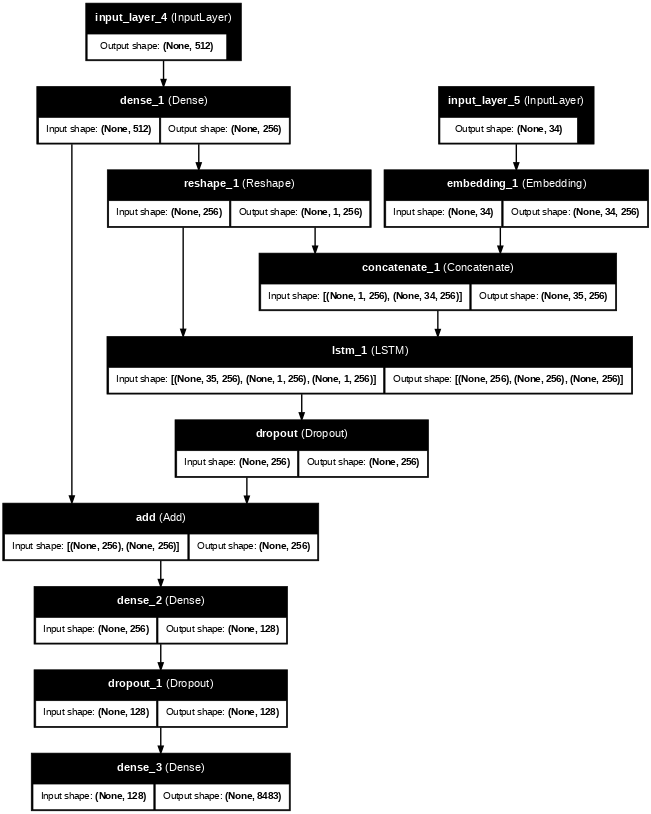

In [ ]:
# encoder1.plot_encoder()
decoder1.plot_decoder()

In [ ]:

encoder1.get_summary()
print()
decoder1.get_summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 256)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 34, 256)        │      2,171,648 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 35, 256)        │              0 │ reshape_1[0][0],       │
│ (Concatenate)             │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 256), (None,   │        525,312 │ concatenate_1[0][0],   │
│                           │ 256), (None, 256)]     │                │ reshape_1[0][0],       │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 8483)           │      1,094,307 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,955,491 (15.09 MB)

 Trainable params: 3,955,491 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

## Initialize Data Generators

In [ ]:
os.mkdir('img_features')
img_feature_dir = os.path.join(os.getcwd(),'img_features')

train_datagen = DataGenerator(train_img, encoder1, train_cap, tokenizer, max_length, batch_size)
train_datagen.run_img_feature_extractor(img_feature_dir, 'train')

In [ ]:
val_datagen = DataGenerator(val_img, encoder1, val_cap, tokenizer, max_length, batch_size)
val_datagen.run_img_feature_extractor(img_feature_dir, 'val')

In [ ]:
test_datagen = DataGenerator(test_img, encoder1, test_cap, tokenizer, max_length, batch_size)
test_datagen.run_img_feature_extractor(img_feature_dir, 'test')

In [ ]:
# shutil.rmtree('/content/train_img_features')
# shutil.rmtree('/content/val_img_features')
# shutil.rmtree('/content/test_img_features')

## Training

### Defining Callbacks

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
model_name = "vgg16_lstm1.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

### Compilation and Fitting

In [ ]:
decoder1.model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
history=decoder1.model.fit(train_datagen,
                   epochs=30,
                   validation_data=val_datagen,
                   callbacks=[checkpoint,
                              earlystopping,
                              learning_rate_reduction])

Epoch 1/30


ValueError: Exception encountered when calling LSTM.call().

[1mShape must be rank 3 but is rank 4 for '{{node functional_15_1/lstm_8_1/CudnnRNNV3}} = CudnnRNNV3[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, num_proj=0, rnn_mode="lstm", seed=0, seed2=0, time_major=false](functional_15_1/concatenate_8_1/concat, functional_15_1/lstm_8_1/ExpandDims, functional_15_1/lstm_8_1/ExpandDims_1, functional_15_1/lstm_8_1/concat_1, functional_15_1/lstm_8_1/Fill)' with input shapes: [?,35,256], [?,1,1,256], [?,1,1,256], [526336], [?].[0m

Arguments received by LSTM.call():
  • sequences=tf.Tensor(shape=(None, 35, 256), dtype=float32)
  • initial_state=['tf.Tensor(shape=(None, 1, 256), dtype=float32)', 'tf.Tensor(shape=(None, 1, 256), dtype=float32)']
  • mask=None
  • training=True

### Training Performance

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()